### **Класифікація тексту для виявлення шахрайства**

**Завдання:**

Запропонувати та реалізувати Proof of Concept (PoC) рішення, яке буде класифікувати текстові описи користувачів із поля **"Про себе"** та виявляти потенційний шахрайський, неприйнятний контент або контактну інформацію.

1. Провести дослідження датасету: переглянути приклади текстів, щоб зрозуміти, як виглядає неприйнятний контент або що може вважатися контактною інформацією.
2. Запропонувати рішення: підібрати метод, який буде ефективним для класифікації тексту. Це може бути проста модель на основі обробки тексту або щось складніше, як нейронна мережа.
3. Реалізувати модель: вибрати та налаштувати модель для класифікації тексту. 
4. Оцінка результату: протестувати модель на наданих даних і перевірити, наскільки добре вона розрізняє нормальні тексти та порушення. 

**Деталі:**

Датасет для цього завдання доступний за [посиланням.](https://docs.google.com/spreadsheets/d/1FKPBf_-D2UbB6zij8snVqqg02WKhMb8lZFhiOj1L6tU/edit?usp=sharing) Вам надано датасет, який містить текстові описи з поля "Про себе" та мітки:

- **label**: позначає, чи є текст неприйнятним:
    - 1 — неприйнятний контент.
    - 0 — нормальний контент.
- **contact_details**: додаткова колонка, яку можна використати для детектування полів, що містять контактну інформацію користувачів.

Дана задача включає дві підзадачі:
1. **Детектування контактної інформації** у полі "Про себе" (телефон, email, посилання).
2. **Виявлення іншого неприйнятного контенту** (підозрілі тексти, нецензурна лексика тощо).

Обидві задачі можна вирішити як окремими моделями, так і спільним рішенням, проте важливо забезпечити здатність чітко розрізняти ці два класи.

### Імпорти

In [87]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report

from sklearn.naive_bayes import MultinomialNB

### Завантаження даних

Завантажимо датасет та переглянимо як виглядають записи

In [88]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [89]:
pd.set_option('display.max_colwidth', None)

In [90]:
df = pd.read_csv('data\Scam _ Not scam 200 - Sheet1.csv')
df.head()

,about_me,label,contact details
0,A︇︆︈l︇︆︈l︇︆︈ ︇︆︈m︇︆︈y︇︆︈ ︇︆︈s︇︆︈e︇︆︈x︇︆︈y︇︆︈ ︇︆︈p︇︆︈h︇︆︈o︇︆︈t︇︆︈o︇︆︈s︇︆︈ ︇︆︈a︇︆︈n︇︆︈d︇︆︈ ︇︆︈v︇︆︈i︇︆︈d︇︆︈e︇︆︈o︇︆︈s︇︆︈ ︇︆︈,1,1
1,"solo busco que me traten como una princesa y me vuelvan más caprichosa de lo que soy, busco un papi bueno que me cumpla los caprichos 💋.rn mi Instagram lun4aa.22",1,1
2,buenas tardes yo busco conocer personas yo quiero alguien que me entienda y queme allude en los económico porque soy una persona muy pobre pero tampoco soy interesada no me gusta pedirle a nadie y tampoco Nome gusta mentirle Ami pareja,1,0
3,Tex бO78OѲ4らч8,1,1
4,"soy madre soltera tengo un hijo de 13 años, soy auxiliar de enfermería, hogareña, romántica, fiel, honesta, busco amistad sincera y transparente inicialmente me gustaría encontrar una persona que me ayude económicamente y si nos entendemos, me gustaría tener una relación seria",1,0


### EDA

In [91]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   about_me         200 non-null    object
 1   label            200 non-null    int64 
 2   contact details  200 non-null    int64 
dtypes: int64(2), object(1)
memory usage: 4.8+ KB


Подивимось на баланс даних

In [92]:
df.label.value_counts()

label
0    104
1     96
Name: count, dtype: int64

In [93]:
df['contact details'].value_counts()

contact details
0    152
1     48
Name: count, dtype: int64

Датасет містить 3 колонки та 200 записів, і не має пропущених значень. Можна також побачити що ми маємо приблизо однакову кількість прийнятних та не прийнятних текстів, і значно більше записів що не містять контактної інформації ніж тих що містять

Візуалізуємо розподіл текстів по довжині

In [94]:
import matplotlib.pyplot as plt

def get_lens(df):
    return [len(text) for text in df]

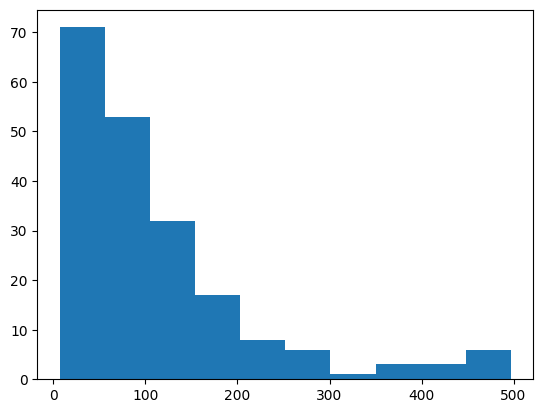

In [95]:
lens = get_lens(df.about_me)
plt.hist(lens);

Подивимось тепер як розподілині дані за довжиною по різним класам

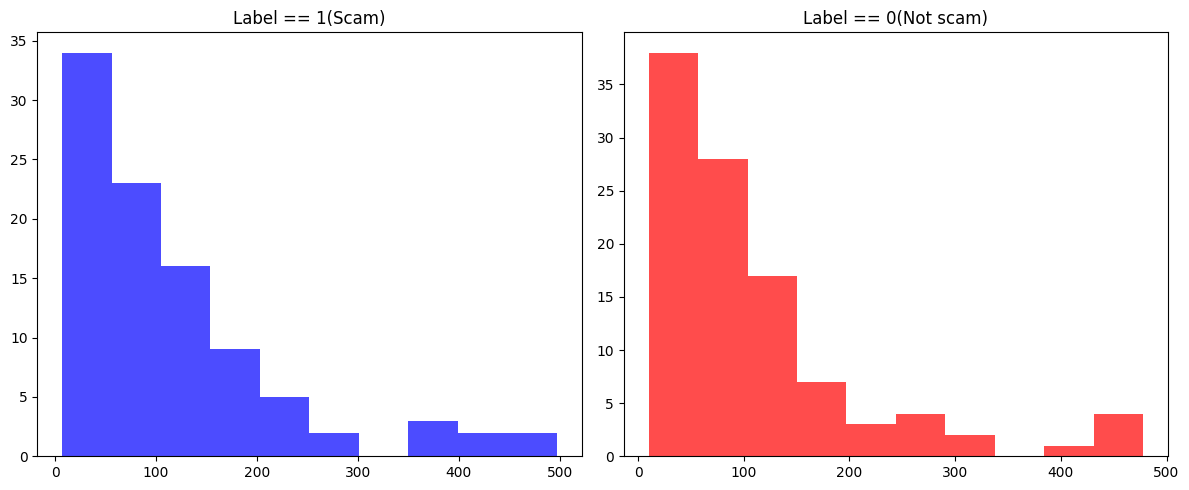

In [96]:
# довжини текстів де label == 1 та label == 0
lens_1 = get_lens(df[df.label == 1].about_me)
lens_0 = get_lens(df[df.label == 0].about_me)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].hist(lens_1, color='blue', alpha=0.7)
axes[0].set_title('Label == 1(Scam)')

axes[1].hist(lens_0, color='red', alpha=0.7)
axes[1].set_title('Label == 0(Not scam)')

plt.tight_layout()

plt.show()

Зробимо те саме для текстів для текстів які містять контактну інформацію

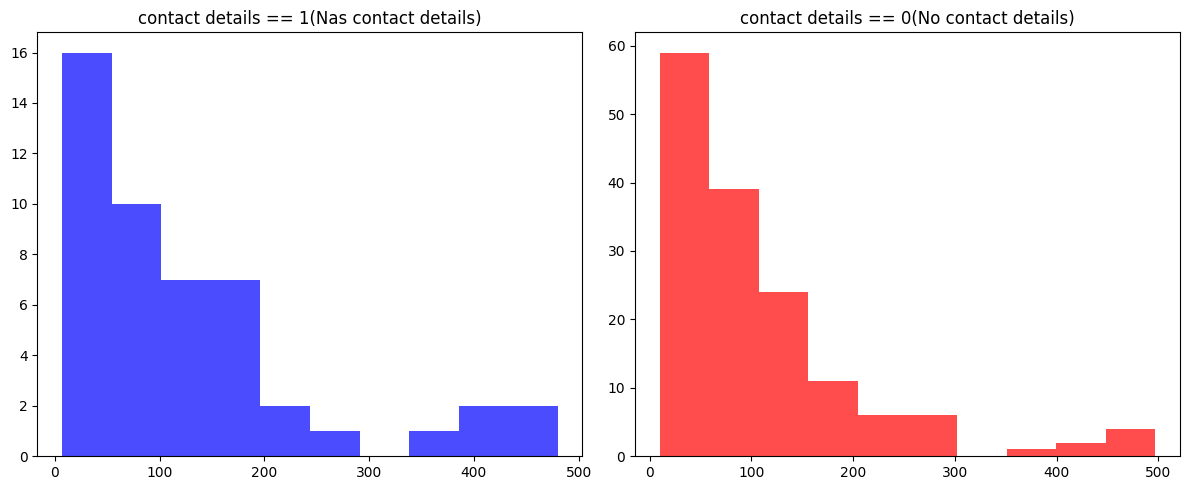

In [97]:
# довжини текстів де contact details == 1 та contact details == 0
lens_1 = get_lens(df[df['contact details'] == 1].about_me)
lens_0 = get_lens(df[df['contact details'] == 0].about_me)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].hist(lens_1, color='blue', alpha=0.7)
axes[0].set_title('contact details == 1(Nas contact details)')


axes[1].hist(lens_0, color='red', alpha=0.7)
axes[1].set_title('contact details == 0(No contact details)')


plt.tight_layout()

plt.show()

Бачимо що тексти розподіляються за довжиною приблизно однаково всередині класів в обох випадках

Подивимось як виглядають дані які можна вважати прийнятними та не прийнятними

In [98]:
# scam
df[df.label == 1].head(10)


,about_me,label,contact details
0,A︇︆︈l︇︆︈l︇︆︈ ︇︆︈m︇︆︈y︇︆︈ ︇︆︈s︇︆︈e︇︆︈x︇︆︈y︇︆︈ ︇︆︈p︇︆︈h︇︆︈o︇︆︈t︇︆︈o︇︆︈s︇︆︈ ︇︆︈a︇︆︈n︇︆︈d︇︆︈ ︇︆︈v︇︆︈i︇︆︈d︇︆︈e︇︆︈o︇︆︈s︇︆︈ ︇︆︈,1,1
1,"solo busco que me traten como una princesa y me vuelvan más caprichosa de lo que soy, busco un papi bueno que me cumpla los caprichos 💋.rn mi Instagram lun4aa.22",1,1
2,buenas tardes yo busco conocer personas yo quiero alguien que me entienda y queme allude en los económico porque soy una persona muy pobre pero tampoco soy interesada no me gusta pedirle a nadie y tampoco Nome gusta mentirle Ami pareja,1,0
3,Tex бO78OѲ4らч8,1,1
4,"soy madre soltera tengo un hijo de 13 años, soy auxiliar de enfermería, hogareña, romántica, fiel, honesta, busco amistad sincera y transparente inicialmente me gustaría encontrar una persona que me ayude económicamente y si nos entendemos, me gustaría tener una relación seria",1,0
5,Мне 16 если хочешь познакомиться пиши мне в Инстаграм _apathy_._,1,1
6,"bin für ein Sextreffen zu haben, wenn du Interesse hast und zeig mein Video",1,0
7,me gustan los hombre mayores y si es posible que me ayude economicamente estoy dispuesta a todo,1,0
8,Ꮥር.emilyqed,1,1
9,"люблю музику і малювати пхпх, можливо не виглядаю на свій вік. Шукаю хлопця який буде забезпечувати як мінімум💕",1,0


In [99]:
# not scam
df[df.label == 0].head(10)


,about_me,label,contact details
40,"Люблю спілкуватись, багато сміятись. Проста, відкрита. Хоббі волейбол, музика. Люблю посидіти в тишині...свій простір. Черпаю сили на природі)",0,0
41,"Живу в Алматы. 🇰🇿 Мужчины рада видеть вас счастливыми, добрыми, мужественными, уважающими другое мнение! Прошу писать словами, а не стикерами😅",0,0
44,busco relación de seria,0,0
45,amante ala música salsa y ala coxinar.,0,0
46,Hay I'm a professional in basketball trying to find a real man to be on my side.,0,0
47,just looking to have fun with some cool people,0,0
48,"Soy una mujer que sabe respetar, con un buen sentido del humor, súper familiar, muy cariñosa y gentil, me gusta cocinar para las personas que amo, amante del orden.rnQuiero encontrar ese ser amado, ese compañero de vida para formar una linda familia.",0,0
49,"Lo más importante en la vida es la honestidad, por lo tanto soy una mujer sincera en todo momento.rnAmo la paz y no me gustan los conflictos. rnLo más valioso en mi vida: mis hijos.",0,0
50,"Olá, sou uma pessoa que gosto de coisas simple, de gente simples,lugares aconchegante e comidas simples ,sei me portar em lugares sofisticados ,mas prefiro a simplicidade,gosto d acampar,um bom vinho,admirar as estrelas o sol a lua, não sou hip,não fumo,não bebo de vez em quando um vinho,mas uma boa conversa é demais,sei respeitar os amigos e guardo todos no coração,amo exercício físico,pilates, amo viajar,não suporto cigarro ,se fumar escove os dentes🤣e por aí vai",0,0
51,I'm a loving n caring person who enjoys cooking n loves going to church ...I'm full of life n happiness..I don't have a child yet n I blve god is going to bless me once I've found my soulmate...,0,0


Тепер подивимось на дані що містять контакту інформацію

In [100]:
# contact details
df[df['contact details'] == 1].head(10)


,about_me,label,contact details
0,A︇︆︈l︇︆︈l︇︆︈ ︇︆︈m︇︆︈y︇︆︈ ︇︆︈s︇︆︈e︇︆︈x︇︆︈y︇︆︈ ︇︆︈p︇︆︈h︇︆︈o︇︆︈t︇︆︈o︇︆︈s︇︆︈ ︇︆︈a︇︆︈n︇︆︈d︇︆︈ ︇︆︈v︇︆︈i︇︆︈d︇︆︈e︇︆︈o︇︆︈s︇︆︈ ︇︆︈,1,1
1,"solo busco que me traten como una princesa y me vuelvan más caprichosa de lo que soy, busco un papi bueno que me cumpla los caprichos 💋.rn mi Instagram lun4aa.22",1,1
3,Tex бO78OѲ4らч8,1,1
5,Мне 16 если хочешь познакомиться пиши мне в Инстаграм _apathy_._,1,1
8,Ꮥር.emilyqed,1,1
10,"amo a mi familia, mis amigas y el amor sincero. ( ¹¹⁵⁷⁴⁶³¹²⁷ )",1,1
11,"💋💋💋I am Angelina by name ... I'm new to this this online things and this is the first time I'm looking for a Life partner online. I might not be available to reply to your message cos am not a full paid member, so if you are interested and care to communicate, Just Message On My E m a i l Sarahhicks 2 0 1 0 1 at gee mail dot cum I’m real and serious about this ...Am online now..Thank You. ?",1,1
12,"Soy muy divertida , sales only🍑rnC0ntenido $",1,1
13,Ig frankimeyyrnalguien que me consienta,1,1
14,M︈︇︉y︈︇︉ ︈︇︉r︈︇︉e︈︇︉a︈︇︉l︈︇︉ ︈︇︉s︈︇︉e︈︇︉x︈︇︉y︈︇︉ ︈︇︉p︈︇︉i︈︇︉c︈︇︉s︈︇︉ ︈︇︉h︈︇︉e︈︇︉r︈︇︉e︈︇︉ ︈︇︉-︈︇︉ ︈︇︉w︈︇︉w︈︇︉w︈︇︉.︈︇︉s︈︇︉a︈︇︉v︈︇︉m︈︇︉.︈︇︉c︈︇︉l︈︇︉u︈︇︉b︈︇︉,1,1


### Підготовка даних

Видалимо з тексту усі зайві символи, такі як емодзі, нестандартні знаки за допомогою герулрниз виразів

In [101]:
df['about_me_cleaned'] = df['about_me'].str.replace(r'[^\w\s@.:/]', '', regex=True).str.lower()
df.head(10)

,about_me,label,contact details,about_me_cleaned
0,A︇︆︈l︇︆︈l︇︆︈ ︇︆︈m︇︆︈y︇︆︈ ︇︆︈s︇︆︈e︇︆︈x︇︆︈y︇︆︈ ︇︆︈p︇︆︈h︇︆︈o︇︆︈t︇︆︈o︇︆︈s︇︆︈ ︇︆︈a︇︆︈n︇︆︈d︇︆︈ ︇︆︈v︇︆︈i︇︆︈d︇︆︈e︇︆︈o︇︆︈s︇︆︈ ︇︆︈,1,1,all my sexy photos and videos
1,"solo busco que me traten como una princesa y me vuelvan más caprichosa de lo que soy, busco un papi bueno que me cumpla los caprichos 💋.rn mi Instagram lun4aa.22",1,1,solo busco que me traten como una princesa y me vuelvan más caprichosa de lo que soy busco un papi bueno que me cumpla los caprichos .rn mi instagram lun4aa.22
2,buenas tardes yo busco conocer personas yo quiero alguien que me entienda y queme allude en los económico porque soy una persona muy pobre pero tampoco soy interesada no me gusta pedirle a nadie y tampoco Nome gusta mentirle Ami pareja,1,0,buenas tardes yo busco conocer personas yo quiero alguien que me entienda y queme allude en los económico porque soy una persona muy pobre pero tampoco soy interesada no me gusta pedirle a nadie y tampoco nome gusta mentirle ami pareja
3,Tex бO78OѲ4らч8,1,1,tex бo78oѳ4らч8
4,"soy madre soltera tengo un hijo de 13 años, soy auxiliar de enfermería, hogareña, romántica, fiel, honesta, busco amistad sincera y transparente inicialmente me gustaría encontrar una persona que me ayude económicamente y si nos entendemos, me gustaría tener una relación seria",1,0,soy madre soltera tengo un hijo de 13 años soy auxiliar de enfermería hogareña romántica fiel honesta busco amistad sincera y transparente inicialmente me gustaría encontrar una persona que me ayude económicamente y si nos entendemos me gustaría tener una relación seria
5,Мне 16 если хочешь познакомиться пиши мне в Инстаграм _apathy_._,1,1,мне 16 если хочешь познакомиться пиши мне в инстаграм _apathy_._
6,"bin für ein Sextreffen zu haben, wenn du Interesse hast und zeig mein Video",1,0,bin für ein sextreffen zu haben wenn du interesse hast und zeig mein video
7,me gustan los hombre mayores y si es posible que me ayude economicamente estoy dispuesta a todo,1,0,me gustan los hombre mayores y si es posible que me ayude economicamente estoy dispuesta a todo
8,Ꮥር.emilyqed,1,1,ꮥር.emilyqed
9,"люблю музику і малювати пхпх, можливо не виглядаю на свій вік. Шукаю хлопця який буде забезпечувати як мінімум💕",1,0,люблю музику і малювати пхпх можливо не виглядаю на свій вік. шукаю хлопця який буде забезпечувати як мінімум


### Виявлення контактної інформації

#### Регулярні вирази

Для виявлення контактної інформації використаємо регулярні вирази, так як ці дані часто мають схожу структуру. 

Визначемо вирази для виявлення номерів телефонів, імейлів, посилань

In [102]:
# визначимо вирази для пошуку контактів
import regex as re

phone_regex = r'\b(\+?\d{1,3}[-.\s]?)?(\(?\d{1,4}\)?[-.\s]?)?[\d.\s-]{5,}\b'
email_regex = r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b'
url_regex = r'\b(?:http[s]?://|www\.)[^\s()<>]+(?:\([\w\d]+\)|([^[:punct:]\s]|/))\b'
nickname_regex = r'\B@[A-Za-z0-9._]+'

# phone_regex = r'\b\d{10,}\b',  
# email_regex = r'[a-zA-Z0-9._%+-]+@[a-zA-Z0-9.-]+\.[a-zA-Z]{2,}',  
# url_regex = r'(http|www)\S+'  

Створимо новий датафрейм в який включимо колонки `'about_me_cleaned'`, `'contact details'`

In [103]:
df_contacts = df[['about_me_cleaned', 'contact details']]
df_contacts.head()

,about_me_cleaned,contact details
0,all my sexy photos and videos,1
1,solo busco que me traten como una princesa y me vuelvan más caprichosa de lo que soy busco un papi bueno que me cumpla los caprichos .rn mi instagram lun4aa.22,1
2,buenas tardes yo busco conocer personas yo quiero alguien que me entienda y queme allude en los económico porque soy una persona muy pobre pero tampoco soy interesada no me gusta pedirle a nadie y tampoco nome gusta mentirle ami pareja,0
3,tex бo78oѳ4らч8,1
4,soy madre soltera tengo un hijo de 13 años soy auxiliar de enfermería hogareña romántica fiel honesta busco amistad sincera y transparente inicialmente me gustaría encontrar una persona que me ayude económicamente y si nos entendemos me gustaría tener una relación seria,0


Додамо колонки в яких зазначимо для кожжного виду контактної інформації чи вона є в тексті `has_phone`, `has_url`, `has_email`, `has_nickname` і колонку що вказує на наявність будь якої контактної інформації `has_contacts`


In [104]:
import warnings

warnings.filterwarnings("ignore" )

In [105]:
df_contacts['has_phone'] = df_contacts['about_me_cleaned'].str.contains(phone_regex, regex=True).astype(int)
df_contacts['has_email'] = df_contacts['about_me_cleaned'].str.contains(email_regex, regex=True).astype(int)
df_contacts['has_url'] = df_contacts['about_me_cleaned'].str.contains(url_regex, regex=True).astype(int)
df_contacts['has_nickname'] = df_contacts['about_me_cleaned'].str.contains(nickname_regex, regex=True).astype(int)

df_contacts['has_contacts'] = df['about_me_cleaned'].apply(
    lambda x: int(
        any([
            bool(re.search(phone_regex, x)),
            bool(re.search(email_regex, x)),
            bool(re.search(url_regex, x)),
            bool(re.search(nickname_regex, x))
        ])
    )
)

df_contacts[df_contacts['has_contacts'] == 1].head(5)

,about_me_cleaned,contact details,has_phone,has_email,has_url,has_nickname,has_contacts
11,i am angelina by name ... im new to this this online things and this is the first time im looking for a life partner online. i might not be available to reply to your message cos am not a full paid member so if you are interested and care to communicate just message on my e m a i l sarahhicks 2 0 1 0 1 at gee mail dot cum im real and serious about this ...am online now..thank you.,1,1,0,0,0,1
14,my real sexy pics here www.savm.club,1,0,0,0,0,1
31,n.e.e.d__f.u.n__m.y__s.c.....n.i.g.h.t.g.i.r.l.m.e.e.t,1,1,0,0,0,1
32,holap soy un chico de 16 de quito sur :3 soy bajo mido 1.58,0,1,0,0,0,1
65,soy cubano peloncito mido 175 de estatura ojos marrones y soy mulato y muy cariñoso,0,1,0,0,0,1


In [106]:
df_contacts['has_contacts'] == df_contacts['contact details']

0      False
1      False
2       True
3      False
4       True
       ...  
195     True
196     True
197     True
198     True
199     True
Length: 200, dtype: bool

In [107]:
acc = (df_contacts['has_contacts'] == df_contacts['contact details']).mean()
acc

0.735

Бачимо що такий метод дав результат, проте залишилось багато неправильно розпізнаних текстів, тож спробуємо інші підходи

#### Logistic Regression

Спробуємо виявляти контактні данні вирішуючи задачу класифікаці. Для цього спочатку векторизуємо дані за допомогою TF-IDF

##### Векторизація з TF-IDF

In [108]:
vectorizer = TfidfVectorizer(max_features=100)
X_text = vectorizer.fit_transform(df['about_me_cleaned']).toarray()

X = pd.DataFrame(X_text)
X.columns = X.columns.astype(str)
y = df['contact details']

Розділимо дані та тренувальну і валідаційну вибірки. 

Зазвичай варто також мати тестовий сет, проте зважаючи на дуже обмежену кількість даинх, в цьому випадку ми можемо обійтися без окремої тестової вибірки.

In [109]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y)

Тепер натренуємо модель логістичної регресії, і оцінимо її продуктивність на тренувальній та валідаційній вибірці, в якості основної метрики оберемо `roc_auc`

In [110]:
log_reg = LogisticRegression(max_iter=500, solver='liblinear')
log_reg.fit(X_train, y_train)

LogisticRegression(max_iter=500, solver='liblinear')

Визначимо функцію для оцінки якості моделі

In [111]:
def eval(model, X, y, name=''):

    # передбачення міток
    pred = model.predict(X)
    # передбачення ймовірностей
    prob = model.predict_proba(X)[:, 1]

    accuracy = accuracy_score(y, pred)
    roc_auc = roc_auc_score(y, prob)
    cl_report= classification_report(y, pred)

    print(f'{name} data\n')
    print(f"acc: {accuracy}\nnroc_auc: {roc_auc}\n\nclassification_report:\n\n{cl_report}")

In [112]:
eval(log_reg, X_train, y_train, 'Train')

Train data

acc: 0.7875
nroc_auc: 0.9262295081967213

classification_report:

              precision    recall  f1-score   support

           0       0.78      1.00      0.88       122
           1       1.00      0.11      0.19        38

    accuracy                           0.79       160
   macro avg       0.89      0.55      0.53       160
weighted avg       0.83      0.79      0.71       160



In [113]:
eval(log_reg, X_val, y_val, 'Validation')


Validation data

acc: 0.75
nroc_auc: 0.8583333333333334

classification_report:

              precision    recall  f1-score   support

           0       0.75      1.00      0.86        30
           1       0.00      0.00      0.00        10

    accuracy                           0.75        40
   macro avg       0.38      0.50      0.43        40
weighted avg       0.56      0.75      0.64        40



### Виявлення нейпринятих описів

In [114]:
y = df['label']

X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y)

#### Logistic Regression

In [117]:
log_reg = LogisticRegression(solver='liblinear')
log_reg.fit(X_train, y_train)

eval(log_reg, X_train, y_train, 'Train')

Train data

acc: 0.85625
nroc_auc: 0.930840244093256

classification_report:

              precision    recall  f1-score   support

           0       0.84      0.89      0.87        83
           1       0.88      0.82      0.85        77

    accuracy                           0.86       160
   macro avg       0.86      0.85      0.86       160
weighted avg       0.86      0.86      0.86       160



In [118]:
eval(log_reg, X_val, y_val, 'Validation')

Validation data

acc: 0.7
nroc_auc: 0.706766917293233

classification_report:

              precision    recall  f1-score   support

           0       0.74      0.67      0.70        21
           1       0.67      0.74      0.70        19

    accuracy                           0.70        40
   macro avg       0.70      0.70      0.70        40
weighted avg       0.70      0.70      0.70        40



Отримана модель дає значно кращі результати на тренувальному наборі, що свідчить про перенавчання

#### Naive Bayes

In [119]:
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)

eval(nb_model, X_train, y_train, 'Train')

Train data

acc: 0.66875
nroc_auc: 0.857142857142857

classification_report:

              precision    recall  f1-score   support

           0       0.65      0.78      0.71        83
           1       0.70      0.55      0.61        77

    accuracy                           0.67       160
   macro avg       0.68      0.66      0.66       160
weighted avg       0.67      0.67      0.66       160



In [120]:
eval(nb_model, X_val, y_val, 'Validation')


Validation data

acc: 0.7
nroc_auc: 0.8020050125313283

classification_report:

              precision    recall  f1-score   support

           0       0.70      0.76      0.73        21
           1       0.71      0.63      0.67        19

    accuracy                           0.70        40
   macro avg       0.70      0.70      0.70        40
weighted avg       0.70      0.70      0.70        40



Друга модель дає приблизно схожі результати на тренувальних та валідаційних даних, що свідчить про її зданість краще генералізувати

#### Можливі підходи

Простим моделям не вдалось досягти бажаних результатів, тому було вирішено спробувати інші підходи.

В цьому завданні ми маємо доволі обмеженй датасет, він має невелику кількість записів різними мовами. 
Доцільно використовувати моделі, які дуже добре розуміють структуру багатьох мов і можуть виявляти нецільове використання символів, наприклад літер для того аби задати телефон.


Ці підходи потребують більше часу на реалізацію і не є безкоштовними, тому нижче описані загальні концепції:

<br>


* **Fine-Tuning LLM**

Цей підхід включає донавчання великих мовних моделей (LLM), таких як GPT-4, на специфічних даних для покращення їхньої точності в певній задачі. Модель тренується додатково на наданому наборі даних, щоб адаптувати її до конкретних вимог, наприклад, для класифікації скам-повідомлень. 

Реалізація цього методу є платною, тому тут загальний підхід реалізації рішення зазначенно тут: [Fine-Tuning Guide - OpenAI](https://platform.openai.com/docs/guides/fine-tuning)

Далі наведено приклад формату навчальних даних:

<pre>
{"messages": [
{"role": "system", "content": "You are a chatbot trained to identify whether a message is a scam or not. Based on examples provided, classify the incoming message as either 'scam' or 'not scam'."}, 
{"role": "user", "content": "люблю музику і малювати пхпх, можливо не виглядаю на свій вік. Шукаю хлопця який буде забезпечувати як мінімум💕"}, 
{"role": "assistant", "content": "Scam"}]}

{"messages": [
{"role": "system", "content": "You are a chatbot trained to identify whether a message is a scam or not. Based on examples provided, classify the incoming message as either 'scam' or 'not scam'."}, 
{"role": "user", "content": "Ꮥር.emilyqed"}, 
{"role": "assistant", "content": "Scam"}]}

{"messages": [
{"role": "system", "content": "You are a chatbot trained to identify whether a message is a scam or not. Based on examples provided, classify the incoming message as either 'scam' or 'not scam'."}, 
{"role": "user", "content": "Hay I'm a professional in basketball trying to find a real man to be on my side."}, 
{"role": "assistant", "content": "Not scam"}]}
</pre>

<br>

* **LLM з Few-Shot Learning**  

Цей підхід передбачає використання великих мовних моделей (LLM), таких як GPT-4, для класифікації або інших задач за допомогою кількох прикладів (few-shot). Модель отримує невелику кількість прикладів з вхідними даними та їхніми правильними мітками, і на основі цього навчається виконувати завдання для нових, невідомих даних без необхідності у великому датасеті. Приклад реалізації: [Few-Shot Examples - LangChain](https://python.langchain.com/docs/how_to/few_shot_examples/)

<br>

* **Multilingual Sentence Embeddings**

Цей підхід включає використання ембедінгів для текстової класифікації, де замість роботи з окремими словами, створюються вектори для цілих речень. Для цього використовуються моделі, такі як Sentence Transformers, щоб отримати векторні представлення тексту. Потім на них застосовуються прості класифікаційні моделі, наприклад, логістична регресія або KNN, для виконання завдання класифікації.

Цей метод є доволі ефективним і дає можливість працювати з різними мовами. Приклад реалізації: [Text Classification Using Sentence Embedding](https://medium.com/@reddyyashu20/build-text-classification-model-using-sentence-embedding-sentence-transformers-part3-a-nlp-b12d701bbd6c)
